# ANALYSIS OF REAL DATA (GSFC)

From real MnKa1, MnKa2 (+other lines) data, it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

**Energy units are (k)eV**

Imports and definitions

PROCESSING

0. Reconstruct data file (singles) with selected record length and library Ka1 and select HR events

1. Read reconstructed events

    1.1. Have a look to events distribution and to variations with baseline and jitter
   
   STUDY OF MnK COMPLEX

2. Jitter correction

    2.1 Plot recon PH vs PHASE (distance between trigger and parabola fit=PHI+LAGS) & Fit a polynomial
    
3. Baseline drift correction

    3.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    3.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
4. Fit histogram of baseline-jitter-corrected energies

    4.1. Test different number of bins and see how residuals respond
    
    4.2. Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then take median value
    
5. Recalibrate energies

6. Plot ALL calibrated energies (No correction for non Mn energies)
    - get new gain scale with fitted line centres
    - recalibrate energies
    - fit again to get FWHM more precisely
    
7. Plot FWHM comparison of different reconstruction methods/lengths    
        

## Imports and definitions

In [2]:
import ipywidgets as widgets
#%matplotlib widget

from subprocess import check_call, STDOUT
import os
from astropy.io import fits
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial as P
import tempfile
from datetime import datetime
import shutil, shlex
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas
import heasoftpy as hsp
from RxLines import RxLines
from fit2GaussAndRatio import fit2GaussAndRatio
from getMaximaDensity import getMaximaDensity
from fit2gauss2hist import fit2gauss2hist
from fit3gauss2hist import fit3gauss2hist
from gainScaleFit import gainScaleLinearFit, gainScalePolyFit
from fitVoigt2hist import fitVoigt2hist
from applyCorr import applyCorr
from commands import run_comm
from clean_records import remove_invalid_records
from annote import AnnoteFinder
from GSFC import *


import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
from numpy import random
from calibLines import *

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
xmlfileSX = os.environ["SIXTE"] + "/share/xifusim/instruments/8pix_tdm.xml" # to reconstruct files with SIRENA (grading)
print(xmlfileSX)

/home/ceballos/sw/SIXTE/git/gitInstall/share/xifusim/instruments/8pix_tdm.xml


In [6]:
# data files
# 32 channels/column * 8 columns
ncols = 8
nrows = 32
channels_matrix = np.zeros((32,8),dtype="i")
for i in range(nrows):
    for j in range(ncols):
        iinit=j*nrows*2 + 1
        ifin=iinit + nrows*2 
        channels_matrix[:,j]=list(range(iinit, ifin, 2))
#print(channels_matrix)
        
channel = "5"
resDir = "channel_" + channel
if not os.path.exists(resDir):
    os.makedirs(resDir)
fileph_singles = resDir + "/pulse_chan" + channel + "_singles.fits" # initial data file with all records and PH_ID column populated
fileph_Kas = resDir + "/pulse_chan" + channel + "_Kas.fits" # data file with only those records with Kas lines (selected by max(ADC))

channel_col = int(int(channel)/(nrows*2))
print("Matrix column for channel", channel, "is column number", channel_col)   

#noXTfile = resDir + "/dataKas_noXT.csv"
noXTfile = resDir + "/Kas_noXT_PHID.csv"

Matrix column for channel 5 is column number 0


In [7]:
# select SIRENA parameters for library Kas creation and reconstruction of data files
samprate=195312.5
plen = 8000
#plen=4096
oflen = 8000
preBuffer = 2000
pBstr = ""
if preBuffer > 0:
    pBstr = "_pB" + str(preBuffer)
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4

thS = channels_noise_thS[channels_ids.index(channel)]
suffix = pBstr + "_filt_thS" + str(thS)


_pB2000_filt_thS3.5


In [8]:
# reconstructed files
evt_libKas = resDir + "/" + "evt_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + ".fits"
evt_libKas_HR = resDir + "/" + "evt_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + "_HR.fits"
evtKas_libKas = resDir + "/" + "evtKas_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + ".fits"
evtKas_libKas_HR = resDir + "/" + "evtKas_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + "_HR.fits"

# library Kas
libKas = resDir + "/" + "library_Kas_"+ str(oflen) + suffix + ".fits"

In [9]:
# gain scale
#lines = (MnKa2_cmass, MnKa1_cmass, MnKb_cmass)
lines = (MnKa2_cmass, MnKa1_cmass, MnKb.energies_eV[MnKb.ilabels.index("Kb1")])
print("MnKa2_cmass, MnKa1_cmass, MnKb1")
print(lines)

MnKa2_cmass, MnKa1_cmass, MnKb1
('5887.37', '5898.00', 6490.89)


In [10]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

# PROCESSING

## 0. Reconstruct data file (singles & Kas) with selected record length and select HR events
(try different record lengths to get variation of FWHM)

In [ ]:
%%script false --no-raise-error
#reconstruct ALL events
comm = ("tesreconstruction Recordfile=" + fileph_singles + " TesEventFile=" + evt_libKas + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
        " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
mess = "Reconstructing ALL data w/ library (Kas)"
run_comm(comm,msg=mess)
print("####################################")
print("Reconstruction of ALL pulses finished")
print("####################################")

In [ ]:
%%script false --no-raise-error
#reconstruct Mn Kas events
comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
        " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
mess = "Reconstructing Kas data w/ library (Kas)"
run_comm(comm,msg=mess)
print("####################################")
print("Reconstruction of Kas pulses finished")
print("####################################")

In [ ]:
%%script false --no-raise-error
# select only HR events (ALL)
expr = "(GRADE1 >= " + str(min(plen,oflen)) + " && GRADE2 > 500)"
result = hsp.fselect(infile=evt_libKas, outfile=evt_libKas_HR, expr=expr, clobber="yes")

In [ ]:
%%script false --no-raise-error
# select only HR events (Mn Kas)
expr = "(GRADE1 >= " + str(min(plen,oflen)) + " && GRADE2 > 500)"
result = hsp.fselect(infile=evtKas_libKas, outfile=evtKas_libKas_HR, expr=expr, clobber="yes")

## 1. Read reconstructed (ALL) events

In [11]:
pulseFile = resDir + "/pulse.txt"
colname = "SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN" 
infile = evt_libKas_HR + "+1"
print("FDUMPing evt file", infile)
result = hsp.fdump(wrap='yes', infile=infile, columns=colname, rows='-', prhead='no', showcol='yes', showunit='no',
                   showrow='no', outfile=pulseFile, clobber='yes', pagewidth=256, more='yes')

all_singles_data_HR = pandas.read_csv(pulseFile, skiprows=0,sep="\s+")
print("\nNumber of initial (all energies) HR pulses:", len(all_singles_data_HR)) 
os.remove(pulseFile)

# exclude events with PHI=0. It'll mean that there is a pulse (undetected) over the rise of another one
data_HR = all_singles_data_HR[(all_singles_data_HR.PHI>0.) | (all_singles_data_HR.PHI<0)]
print("\nNumber of non-excluded events (all energies) HR pulses (after PHI selection):", len(data_HR)) 

# exclude high baseline events: they have a truncated pulse at the beginnig of the record
data_HR = data_HR[(data_HR.BSLN<8325)]
print("\nNumber of non-excluded events (all energies) HR pulses (after BSLN selection):", len(data_HR)) 

print("MinSIGNAL, MaxSIGNAL=", min(data_HR.SIGNAL), max(data_HR.SIGNAL))
print("MinBSLN, MaxBSLN=", min(data_HR.BSLN), max(data_HR.BSLN))
display(data_HR)


FDUMPing evt file channel_5/evt_pulse_chan5_libKas_pL8000_OPTFILT8000_pB2000_filt_thS3.5_HR.fits+1

Number of initial (all energies) HR pulses: 45018

Number of non-excluded events (all energies) HR pulses (after PHI selection): 45008

Number of non-excluded events (all energies) HR pulses (after BSLN selection): 45006
MinSIGNAL, MaxSIGNAL= 0.237655860814926 12.89661001176203
MinBSLN, MaxBSLN= 7746.215053763442 8112.046594982079


,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,5.902052,0,8000,8000,0.499914,0,7815.443932
1,6.361305,1,8000,8000,-0.196627,0,7816.058884
2,5.901539,2,8000,8000,0.038727,0,7813.750640
3,5.895723,3,8000,8000,0.023820,0,7816.303123
4,6.366998,4,8000,8000,0.381937,0,7814.694316
...,...,...,...,...,...,...,...
45013,5.896149,46870,8000,8000,-0.001953,0,7773.057860
45014,5.892778,46871,8000,8000,0.389952,0,7773.845366
45015,5.900998,46872,8000,8000,0.281726,0,7772.790579
45016,5.898789,46873,8000,8000,-0.422852,0,7774.009217


### 1.1 Have a look to (ALL) events distribution and to variations with baseline and jitter

In [12]:
# main lines in reconstructed PH units
PHlines = dict()
if plen==8000:
    PHlines = {
           "Sc-Ka": (4.250,4.400),
           "Ti-Ka": (4.675,4.750),
           "V-Ka":  (5.050,5.125),
           "Cr-Ka": (5.400,5.600),
           "Mn-Ka": (5.860,5.920),
           #"Mn-Ka": (5.875,5.910),
           "Fe-Ka": (6.250,6.350),
           "Mn-Kb": (6.340,6.400),
           "Co-Ka": (6.630,6.800),
           "Ni-Ka": (7.050,7.150),
           "Cu-Ka": (7.450,7.550),
           "Zn-Ka": (7.900,7.950),
           "Ge-Ka": (8.700,8.790),
           "Br-Ka": (9.800,10.100)
    } 
elif plen==4096:
    PHlines = {
           "Sc-Ka": (6.250,6.350),
           "Ti-Ka": (6.650,6.730),
           "V-Ka":  (7.000,7.100),
           "Cr-Ka": (7.400,7.550),
           "Mn-Ka": (7.830,7.880),
           "Fe-Ka": (8.200,8.300),
           "Mn-Kb": (8.310,8.350),
           "Co-Ka": (8.600,8.730),
           "Ni-Ka": (9.050,9.100),
           "Cu-Ka": (9.400,9.550),
           "Zn-Ka": (9.850,9.950),
           "Ge-Ka": (10.700,10.790),
           "Br-Ka": (11.900,12.050)
    }

(6340.0, 6400.0)

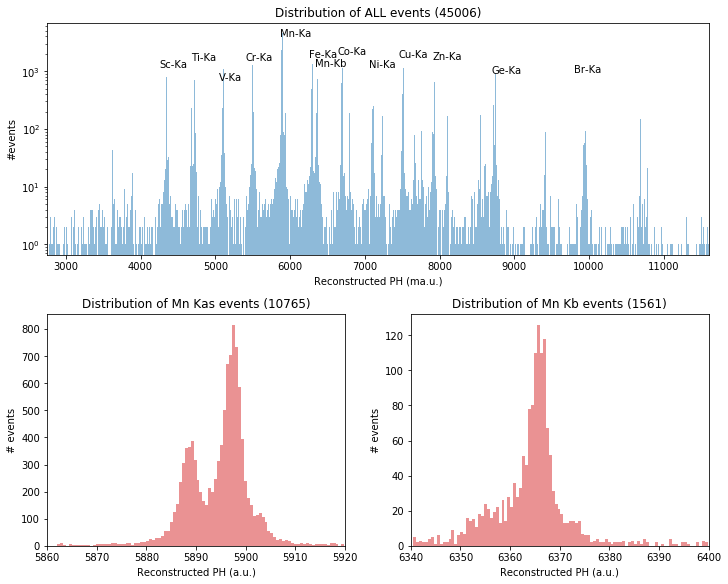

In [13]:
#%%script false --no-raise-error

# Events PH distribution
plt.close()
fig = plt.figure(constrained_layout=True, figsize=(10,8))
gs = GridSpec(2, 2, figure=fig)

# Have a look to histogram of ALL reconstructed data
ax1 = fig.add_subplot(gs[0, :])
npulses = len(data_HR.SIGNAL)
ax1.set_xlabel("Reconstructed PH (ma.u.)")
ax1.set_ylabel("#events")
ax1.set_title(("Distribution of ALL events (" + str(npulses) + ")"))
ax1.hist(1e3*data_HR.SIGNAL, bins=2000, density=False, label="Histogram", alpha=0.5, log=True)
xmin = 1e3*PHlines["Sc-Ka"][0] - 1500
xmax = 1e3*PHlines["Br-Ka"][1] + 1500
ax1.set_xlim(xmin,xmax)
for line in PHlines:
    PHmin,PHmax = PHlines[line]
    if line == "Mn-Ka":
        ax1.text(1e3*PHmin, 4e3, line)
    else:
        ax1.text(1e3*PHmin, 3e3*random.uniform(0.1,0.7), line)

# Have a look to histogram of Mn Kas
ax2 = fig.add_subplot(gs[1, 0])
minPH,maxPH = PHlines["Mn-Ka"]
npulses = len(data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL)
ax2.hist(1e3*data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL, bins=100, density=False, label="Histogram", alpha=0.5, color="tab:red")
ax2.set_xlabel("Reconstructed PH (a.u.)")
ax2.set_ylabel("# events")
ax2.set_title(("Distribution of Mn Kas events (" + str(npulses) + ")"))
ax2.set_xlim(1e3*minPH,1e3*maxPH)
#ax3.set_xlim(8650,8900) # 0-pad 2048
#ax3.set_xlim(9750,9900) # 0-pad 1024

# Have a look to histogram of Kb
ax3 = fig.add_subplot(gs[1, 1])
(minPH,maxPH) = PHlines["Mn-Kb"]
#(minKb,maxKb) = (9.210, 9.310) # 0-pad 2048
#(minKb,maxKb) = (10.275, 10.350) # 0-pad
npulses = len(data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL)
ax3.hist(1e3*data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL, bins=100, density=False, label="Histogram", alpha=0.5, color="tab:red")
ax3.set_xlabel("Reconstructed PH (a.u.)")
ax3.set_ylabel("# events")
ax3.set_title(("Distribution of Mn Kb events (" + str(npulses) + ")"))
ax3.set_xlim(1e3*minPH,1e3*maxPH)
#ax4.set_xlim(9210,9310) # 0-pad 2048
#ax4.set_xlim(10275,10350) # 0-pad 1024



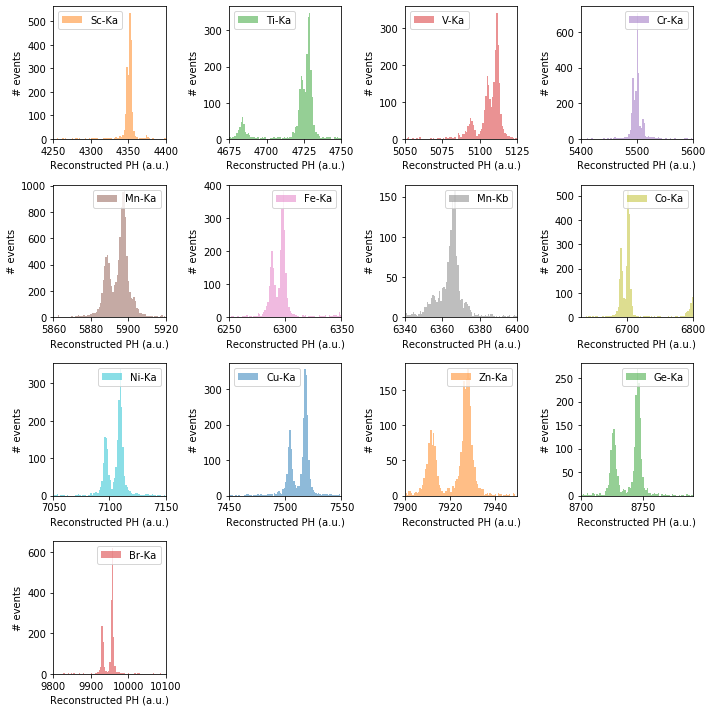

In [14]:
fig = plt.figure(figsize=(10,10))
i = 0
for line in PHlines:
    i+=1
    color="C"+str(i)
    #print("Plotting line=", PHlines[line])
    PHmin,PHmax = PHlines[line]
    npulses = len(data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)].SIGNAL)
    ax = fig.add_subplot(4, 4, i)
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)].SIGNAL
    ax.hist(1e3*dataLine, bins=80, density=False, alpha=0.5, color=color, label=line)
    ax.set_xlabel("Reconstructed PH (a.u.)")
    ax.set_ylabel("# events")
    ax.set_xlim(1e3*PHmin,1e3*PHmax)
    ax.legend()

fig.tight_layout()


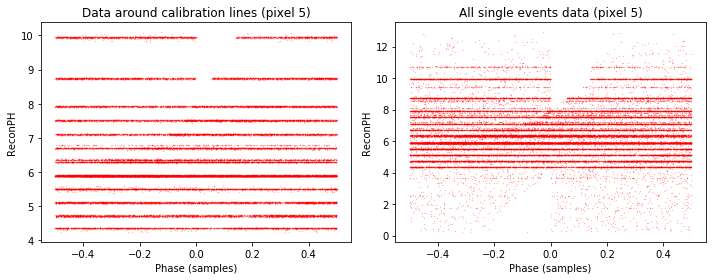

In [16]:
# plot jitters
plt.close()
phase_HR = data_HR.PHI + data_HR.LAGS
base_HR = data_HR.BSLN

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("Phase (samples)")
ax1.set_ylabel("ReconPH")
 
for line in PHlines:
    PHmin,PHmax = PHlines[line]
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
    phase_HR = dataLine.PHI + dataLine.LAGS
    phase_HR = dataLine.PHI 
    # arrival phase to (-0.5,0.5) interval
    lagPhase = phase_HR - 1.*np.trunc(phase_HR/0.5)
    ax1.scatter(lagPhase, dataLine.SIGNAL, alpha=0.5,s=0.05, color="red")
    tit = "Data around calibration lines (pixel " + channel + ")"
    ax1.set_title(tit)
    #ax1.scatter(phase_HR, dataLine.LAGS, alpha=0.5)
    
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("Phase (samples)")
ax2.set_ylabel("ReconPH")
#lagPhase = all_singles_data_HR.PHI - 1.*np.trunc(all_singles_data_HR.PHI/0.5)
#ax2.scatter(lagPhase, all_singles_data_HR.SIGNAL, alpha=0.5,s=0.05, color="blue")
lagPhase = data_HR.PHI - 1.*np.trunc(data_HR.PHI/0.5)
#lagPhase = data_HR.PHI
ax2.scatter(lagPhase, data_HR.SIGNAL, alpha=0.5,s=0.05, color="red")
#ax2.set_ylim(3.5,10.5)
tit = "All single events data (pixel " + channel + ")"
ax2.set_title(tit)
fig.tight_layout()

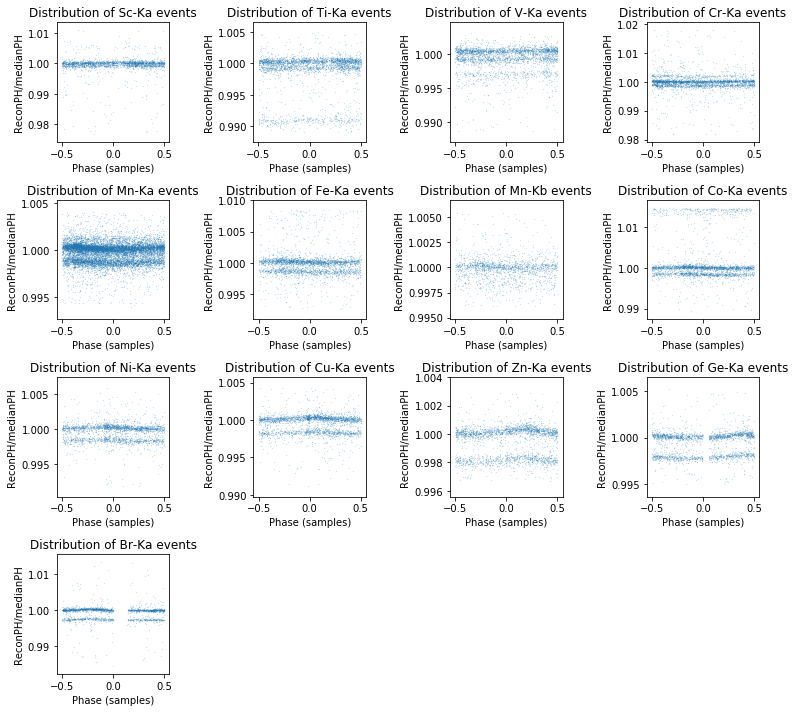

In [17]:
fig = plt.figure(figsize=(11,10))
i = 0
for line in PHlines:
    i+=1
    #print("Plotting line=", PHlines[line])
    PHmin,PHmax = PHlines[line]
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
    dataLine_norm = dataLine.SIGNAL/(np.median(dataLine.SIGNAL))
    phase_HR = dataLine.PHI + dataLine.LAGS
    phase_HR = dataLine.PHI - 1.*np.trunc(dataLine.PHI/0.5)
    ax1 = fig.add_subplot(4, 4, i)
    ax1.set_xlabel("Phase (samples)")
    ax1.set_ylabel("ReconPH/medianPH")
    title = "Distribution of " + line + " events"
    ax1.set_title(title)
    ax1.scatter(phase_HR, dataLine_norm, alpha=0.5,s=0.03)
    #ax1.scatter(phase_HR, dataLine.LAGS, alpha=0.5)

fig.tight_layout()

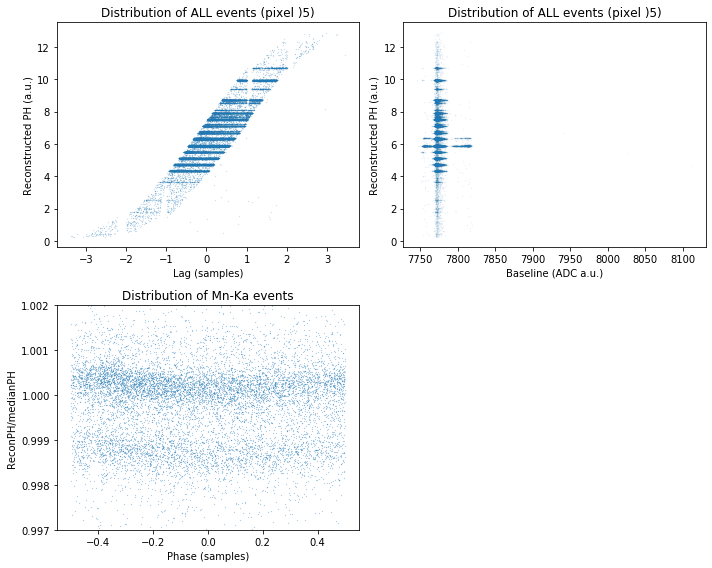

In [18]:
# Jitter and baseline distribution
plt.close()
phase_HR = data_HR.PHI + data_HR.LAGS
base_HR = data_HR.BSLN

tit = "Distribution of ALL events (pixel )" + channel + ")"

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel("Lag (samples)")
ax1.set_ylabel("Reconstructed PH (a.u.)")
ax1.set_title(tit)
ax1.scatter(phase_HR, data_HR.SIGNAL, alpha=0.5, s=0.03)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel("Baseline (ADC a.u.)")
ax2.set_ylabel("Reconstructed PH (a.u.)")
ax2.set_title(tit)
ax2.scatter(base_HR, data_HR.SIGNAL, alpha=0.2, s=0.03)

line = "Mn-Ka"
PHmin,PHmax = PHlines[line]
dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
dataLine_norm = dataLine.SIGNAL/(np.median(dataLine.SIGNAL))
phase_HR = dataLine.PHI - 1.*np.trunc(dataLine.PHI/0.5)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_xlabel("Phase (samples)")
ax3.set_ylabel("ReconPH/medianPH")
title = "Distribution of " + line + " events"
ax3.set_title(title)
ax3.scatter(phase_HR, dataLine_norm, alpha=0.8,s=0.03)
ax3.set_ylim(0.997,1.002)
fig.tight_layout()

# STUDY Mn K complex 

## 1. Read reconstructed (Kas) events

In [19]:
pulseFile = resDir + "/pulse.txt"
colname = "TIME,SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN" 
infile = evtKas_libKas_HR + "+1"
print("FDUMPing evt file", infile)
result = hsp.fdump(wrap='yes', infile=infile, columns=colname, rows='-', prhead='no', showcol='yes', showunit='no',
                   showrow='no', outfile=pulseFile, clobber='yes', pagewidth=256, more='yes')

dataKas_HR = pandas.read_csv(pulseFile, skiprows=0,sep="\s+")
#print("\nNumber of initial (all energies) HR pulses:", len(data_HR)) 
os.remove(pulseFile)
if len(dataKas_HR[dataKas_HR.PHI == 0.].PHI >0):
    print("Warning: some dataKas have PHI==0. => double undetected pulse?")

display(dataKas_HR)
print("MinSIGNAL, MaxSIGNAL=", min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))



FDUMPing evt file channel_5/evtKas_pulse_chan5_libKas_pL8000_OPTFILT8000_pB2000_filt_thS3.5_HR.fits+1


,TIME,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,1.578693e+09,5.902052,0,8000,8000,0.499914,0,7815.443932
1,1.578693e+09,5.901539,2,8000,8000,0.038727,0,7813.750640
2,1.578693e+09,5.895723,3,8000,8000,0.023820,0,7816.303123
3,1.578693e+09,5.895755,7,8000,8000,0.193128,0,7814.715310
4,1.578693e+09,5.904514,8,8000,8000,0.279153,0,7814.933948
...,...,...,...,...,...,...,...,...
9772,1.578743e+09,5.891114,46869,8000,8000,0.405762,0,7769.918587
9773,1.578743e+09,5.896149,46870,8000,8000,-0.001953,0,7773.057860
9774,1.578743e+09,5.892778,46871,8000,8000,0.389952,0,7773.845366
9775,1.578743e+09,5.900998,46872,8000,8000,0.281726,0,7772.790579


MinSIGNAL, MaxSIGNAL= 5.870384968931207 5.9134895051655905


## 0. Remove XT from files in same TDM column

In [20]:
%%script false --no-raise-error
# reconstruct pulses in the other files of the same column
for ich in channels_matrix[:,channel_col]:
    colDir = "channel_" + str(ich)
    if not os.path.exists(colDir):
        os.makedirs(colDir)


In [21]:
%%script false --no-raise-error
t1 = 0.002 # (s) dT backwards according to GSFC doc
t2 = 0.002 # (s) dT forwards
time_window = [t1, t2]

In [22]:
%%script false --no-raise-error
# reconstruct events in Low res mode, because only ARRIVAL TIME (detection) in interesting
print ("Reconstructing events for colum of channel", channel)
for ich in channels_matrix[:,channel_col]:
    if ich==channel:
        continue
    file_same_col = "/run/media/ceballos/datar2/pulse_chan" + str(ich) + ".fits"
    fileXT = "pulse_detection_chan" + str(ich) + ".fits" #Full events file in channel ich
    if os.path.isfile(file_same_col) and not os.path.isfile(fileXT) :
        comm = ("tesreconstruction Recordfile=" + file_same_col + " TesEventFile=" + fileXT + " PulseLength=" + str(oflen) +
            " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
            " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
            " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=8")
        mess = "detecting pulses for channel:" + str(ich)
        run_comm(comm,msg=mess)


In [23]:
%%script false --no-raise-error
dataKas_noXT = dataKas_HR.copy() # inititalize non-XT events
print("Starting with non-XT", len(dataKas_noXT.SIGNAL)," Kas events in channel", channel)

# Select only non-XT events
for ich in channels_matrix[:,channel_col]:
    print ("Analysing events in channel", ich)
    if ich==channel:
        continue
    fileXT = "pulse_detection_chan" + str(ich) + ".fits" #Full events file in channel ich
    if os.path.isfile(fileXT) :
        f = fits.open(fileXT)
        TIMExt = f["EVENTS"].data['TIME']
        PHIDxt = f["EVENTS"].data['PH_ID']
        f.close()
        # look for events in fileXT synchronous with evts in fileph_Kas    
    
        xt0 = len(dataKas_noXT.TIME)
        for i in range(len(TIMExt)):
            #dataKas_noXT = dataKas_noXT[(abs(dataKas_noXT.TIME-TIMExt[i])>sepTH)]
            dataKas_noXT = dataKas_noXT[((dataKas_noXT.TIME-TIMExt[i])>t1) | 
                                       ((TIMExt[i]-dataKas_noXT.TIME)>t2)] 
            #dataKas_XT = dataKas_HR[(abs(dataKas_HR.TIME-TIMExt[i])<sepTH)]
            #if len(dataKas_XT.TIME >0):
            #    display(dataKas_HR[(abs(dataKas_HR.TIME-TIMExt[i])<sepTH)])
            #time_dist = np.abs(np.array(dataKas_HR.TIME)-TIMExt[i])
            #idx_close = np.argwhere(time_dist < sepTH)[:,0]
            #if len(idx_close)>0:
            #    print("XT photon", i, "in channel", ich, "is very close to Kas photon(s) in df row:",idx_close)
        xt1 = len(dataKas_noXT.TIME)    
        if xt1 < xt0:
            diff=xt0-xt1
            print("Removed",diff,"photons from channel",channel," which have (channel",ich,") XT photons in pulse length")
            print("Current number of non-XT events in channel", channel," is ", len(dataKas_noXT.TIME))

In [24]:
%%script false --no-raise-error
rem = len(dataKas_HR.TIME) - len(dataKas_noXT.TIME)
print("Initial Kas photons:", len(dataKas_HR.TIME))
print("Removed", rem, "photons from channel", channel, "list")
print("Remining photons:", len(dataKas_noXT.TIME))
display(dataKas_noXT)
Kas_noXT_PHID = dataKas_noXT.PH_ID.to_numpy()
display(Kas_noXT_PHID)

In [25]:
# save or read file with PH_ID of non-XT events (reconstruction method changes pandas datasets (SIGNAL, PHI))
if os.path.isfile(noXTfile):
    Kas_noXT_PHID = np.loadtxt(noXTfile)
else:
    np.savetxt(noXTfile, Kas_noXT_PHID)
dataKas_noXT = dataKas_HR[(dataKas_HR.PH_ID.isin(Kas_noXT_PHID))]
display(dataKas_noXT)

,TIME,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,1.578693e+09,5.902052,0,8000,8000,0.499914,0,7815.443932
2,1.578693e+09,5.895723,3,8000,8000,0.023820,0,7816.303123
3,1.578693e+09,5.895755,7,8000,8000,0.193128,0,7814.715310
4,1.578693e+09,5.904514,8,8000,8000,0.279153,0,7814.933948
5,1.578693e+09,5.890400,9,8000,8000,-0.173076,0,7813.927291
...,...,...,...,...,...,...,...,...
9770,1.578743e+09,5.898105,46641,8000,8000,0.086270,0,7770.089094
9771,1.578743e+09,5.890637,46644,8000,8000,-0.384357,0,7772.384025
9772,1.578743e+09,5.891114,46869,8000,8000,0.405762,0,7769.918587
9773,1.578743e+09,5.896149,46870,8000,8000,-0.001953,0,7773.057860


## 2. Jitter correction

### 2.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI) & fit polynomial
Phase = PHI
Lags = PHI + LAGS

Number of pulses in dataKas_noXT:  8371

Number of pulses in dataKb_HR:  1561


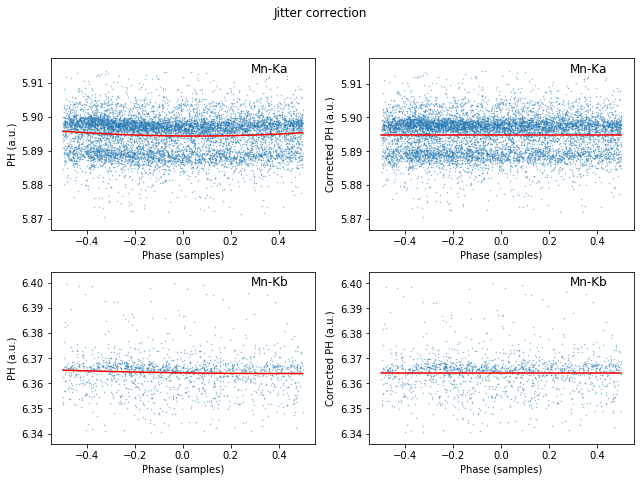

In [26]:
plt.close()
fig = plt.figure(figsize=(9, 7))
fig.suptitle("Jitter correction")
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
# 
PHminKas, PHmaxKas = PHlines["Mn-Ka"] 
PHminKb, PHmaxKb = PHlines["Mn-Kb"]

# dataKas_HR already read above; dataKb not corrected for XT!
dataKb_HR = data_HR[(data_HR.SIGNAL>PHminKb) & (data_HR.SIGNAL<PHmaxKb)]

#print("Number of pulses in dataKas_HR: ", len(dataKas_HR))
#phaseKas_HR = dataKas_HR.PHI + dataKas_HR.LAGS

# apply jitter correction to Kas
print("Number of pulses in dataKas_noXT: ", len(dataKas_noXT))
phaseKas_HR = dataKas_noXT.PHI + dataKas_noXT.LAGS
phaseKas_HR = dataKas_noXT.PHI - 1.*np.trunc(dataKas_noXT.PHI/0.5)

jitterCorr = applyCorr(xdata=phaseKas_HR,ydata=dataKas_noXT.SIGNAL, deg=4,verbose=0)
dataKas_HR_jitter = jitterCorr.ydata_corr
jitterCorr.plotDataFit(ax0=ax1, alpha=0.5, size=1)
ax1.set_xlabel("Phase (samples)")
ax1.set_ylabel("PH (a.u.)")
ax1.text(0.90, 0.90, "Mn-Ka",verticalalignment='bottom', horizontalalignment='right',
        transform=ax1.transAxes, fontsize=12)
#        check correction...is flat now?
jitterCorr.plotDataCorrFit(ax0=ax2, alpha=0.5, size=1)
ax2.set_xlabel("Phase (samples)")
ax2.set_ylabel("Corrected PH (a.u.)")
ax2.text(0.90, 0.90, "Mn-Ka",verticalalignment='bottom', horizontalalignment='right',
        transform=ax2.transAxes, fontsize=12)


# apply jitter correction to Kb
print("\nNumber of pulses in dataKb_HR: ", len(dataKb_HR))
phaseKb_HR = dataKb_HR.PHI + dataKb_HR.LAGS
phaseKb_HR = dataKb_HR.PHI - 1.*np.trunc(dataKb_HR.PHI/0.5)

jitterCorr = applyCorr(xdata=phaseKb_HR,ydata=dataKb_HR.SIGNAL, deg=3,verbose=0)
dataKb_HR_jitter = jitterCorr.ydata_corr
jitterCorr.plotDataFit(ax0=ax3, alpha=0.5, size=1)
ax3.set_xlabel("Phase (samples)")
ax3.set_ylabel("PH (a.u.)")
ax3.text(0.90, 0.90, "Mn-Kb",verticalalignment='bottom', horizontalalignment='right',
        transform=ax3.transAxes, fontsize=12)
#        check correction...is flat now?
jitterCorr.plotDataCorrFit(ax0=ax4, alpha=0.5, size=1)
ax4.set_xlabel("Phase (samples)")
ax4.set_ylabel("Corrected PH (a.u.)")
ax4.text(0.90, 0.90, "Mn-Kb",verticalalignment='bottom', horizontalalignment='right',
        transform=ax4.transAxes, fontsize=12)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])



## 3. Baseline correction

### Plot jiterr_recon PH vs Baseline & Fit polynomial


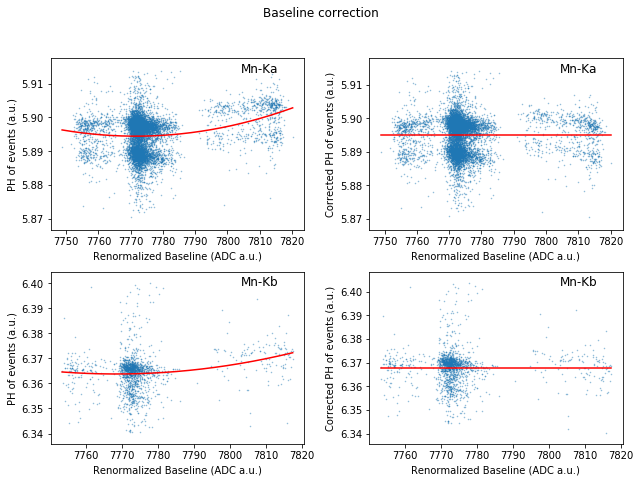

In [27]:
plt.close()
fig = plt.figure(figsize=(9, 7))
fig.suptitle("Baseline correction")
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

#print("Mn Kas")
baseKas_HR = dataKas_noXT.BSLN
baseCorr = applyCorr(xdata=baseKas_HR,ydata=dataKas_HR_jitter, deg=4,verbose=0)
dataKas_HR_jitter_bsln = baseCorr.ydata_corr
baseCorr.plotDataFit(ax0=ax1, alpha=0.5, size=1)
ax1.set_xlabel("Renormalized Baseline (ADC a.u.)")
ax1.set_ylabel("PH of events (a.u.)")
ax1.text(0.90, 0.90, "Mn-Ka",verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes, fontsize=12)
baseCorr.plotDataCorrFit(ax0=ax2, alpha=0.5, size=1)
ax2.set_xlabel("Renormalized Baseline (ADC a.u.)")
ax2.set_ylabel("Corrected PH of events (a.u.)")
ax2.text(0.90, 0.90, "Mn-Ka",verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes, fontsize=12)
annotes = dataKas_HR.PH_ID
af =  AnnoteFinder(baseKas_HR,dataKas_HR_jitter, annotes, ax=ax1)
fig.canvas.mpl_connect('button_press_event', af)

#print("\nMn Kb")
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
baseKb_HR = dataKb_HR.BSLN
baseCorr = applyCorr(xdata=baseKb_HR,ydata=dataKb_HR_jitter, deg=4,verbose=0)
dataKb_HR_jitter_bsln = baseCorr.ydata_corr
baseCorr.plotDataFit(ax0=ax3, alpha=0.5, size=1)
ax3.set_xlabel("Renormalized Baseline (ADC a.u.)")
ax3.set_ylabel("PH of events (a.u.)")
ax3.text(0.90, 0.90, "Mn-Kb",verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes, fontsize=12)
baseCorr.plotDataCorrFit(ax0=ax4, alpha=0.5, size=1)
ax4.set_xlabel("Renormalized Baseline (ADC a.u.)")
ax4.set_ylabel("Corrected PH of events (a.u.)")
ax4.text(0.90, 0.90, "Mn-Kb",verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes, fontsize=12)

annotes = dataKb_HR.PH_ID
af =  AnnoteFinder(baseKb_HR,dataKb_HR_jitter, annotes, ax=ax3)
fig.canvas.mpl_connect('button_press_event', af)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])

## 4. Drift correction (PH versus TIME)

/home/ceballos/sw/anaconda3/envs/sixteENV/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/ceballos/sw/anaconda3/envs/sixteENV/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


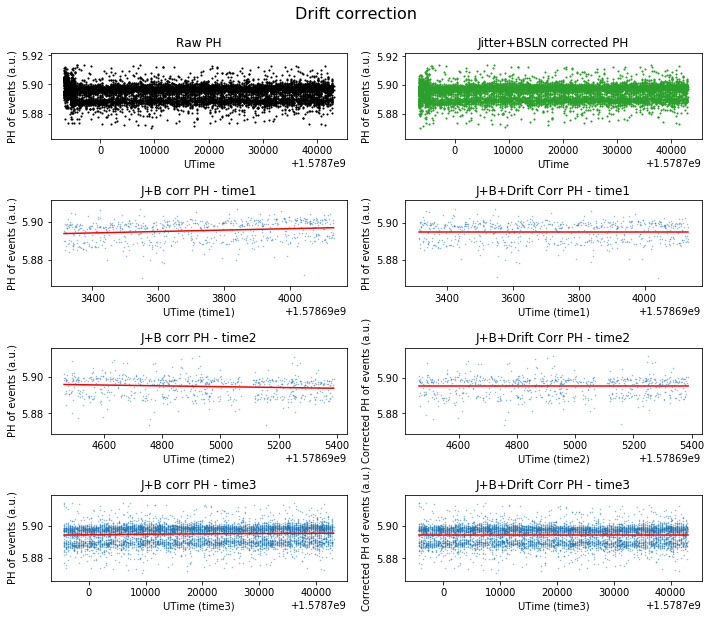

In [28]:
plt.close()
fig = plt.figure(figsize=(10, 9))
fig.suptitle("Drift correction",fontsize=16)

ax1 = fig.add_subplot(4,2,1)
ax2 = fig.add_subplot(4,2,2)
ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)
ax5 = fig.add_subplot(4,2,5)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

# FIT DIFFERENT time-intervals

time_break1 = 4250 + 1.57869e9
time_break2 = 5500 + 1.57869e9
#indices1 = np.argwhere(np.array(dataKas_HR.TIME)<time_break1)[:,0]
#indices2 = np.argwhere((np.array(dataKas_HR.TIME)>time_break1) & (np.array(dataKas_HR.TIME)<time_break2))[:,0]
#indices3 = np.argwhere(np.array(dataKas_HR.TIME)>time_break2)[:,0]
indices1 = np.argwhere(np.array(dataKas_noXT.TIME)<time_break1)[:,0]
indices2 = np.argwhere((np.array(dataKas_noXT.TIME)>time_break1) & (np.array(dataKas_noXT.TIME)<time_break2))[:,0]
indices3 = np.argwhere(np.array(dataKas_noXT.TIME)>time_break2)[:,0]

dataKas_HR_jitter_bsln_drift = np.zeros(len(dataKas_HR_jitter_bsln))
n1 = len(indices1)
n2 = len(indices2)
n3 = len(indices3)

#idxsort = np.argsort(timeKas_HR)
#ax0.scatter(np.arange(len(idxsort)), dataKas_HR.SIGNAL[idxsort], marker=".", s=5)
#ax1.scatter(dataKas_HR.TIME, dataKas_HR.SIGNAL,marker=".", s=5, color='black')
ax1.scatter(dataKas_noXT.TIME, dataKas_noXT.SIGNAL,marker=".", s=5, color='black')
ax1.set_xlabel("UTime")
ax1.set_ylabel("PH of events (a.u.)")
ax1.set_title("Raw PH")
ax2.scatter(dataKas_noXT.TIME, dataKas_HR_jitter_bsln,marker=".", s=5, color='tab:green')
ax2.set_xlabel("UTime")
ax2.set_ylabel("PH of events (a.u.)")
ax2.set_title("Jitter+BSLN corrected PH")


#dataKas_HR_jitter_bsln_drift[0:n1] = applyCorr(ydata=dataKas_HR_jitter_bsln[indices1], deg=1, xdata=dataKas_HR.TIME[indices1],
#                                          ax0=ax3, ax1=ax4, alpha=1)
#dataKas_HR_jitter_bsln_drift[0:n1] = applyCorr2(ydata=dataKas_HR_jitter_bsln[dataKas_noXT.TIME<time_break1], deg=1, 
#                                               xdata=dataKas_noXT[dataKas_noXT.TIME<time_break1].TIME,
#                                               ax0=ax3, ax1=ax4, alpha=1)
timeCorr1 = applyCorr(ydata=dataKas_HR_jitter_bsln[dataKas_noXT.TIME<time_break1], deg=1, 
                      xdata=dataKas_noXT[dataKas_noXT.TIME<time_break1].TIME, verbose=0)
dataKas_HR_jitter_bsln_drift[0:n1] = timeCorr1.ydata_corr
timeCorr1.plotDataFit(ax0=ax3, alpha=0.5, size=1)
timeCorr1.plotDataCorrFit(ax0=ax4, alpha=0.5, size=1)
ax3.set_xlabel("UTime (time1)")
ax3.set_ylabel("PH of events (a.u.)")
ax3.set_title("J+B corr PH - time1")
ax4.set_xlabel("UTime (time1)")
ax4.set_ylabel("PH of events (a.u.)")
ax4.set_title("J+B+Drift Corr PH - time1")


#dataKas_HR_jitter_bsln_drift[n1:(n1+n2)] = applyCorr(ydata=dataKas_HR_jitter_bsln[indices2],deg=1, xdata=dataKas_HR.TIME[indices2],
#                                          ax0=ax5, ax1=ax6, alpha=1)
#dataKas_HR_jitter_bsln_drift[n1:(n1+n2)] = applyCorr2(ydata=dataKas_HR_jitter_bsln[(dataKas_noXT.TIME>time_break1) & (dataKas_noXT.TIME<time_break2)], 
#                                                     xdata=dataKas_noXT[(dataKas_noXT.TIME>time_break1) & (dataKas_noXT.TIME<time_break2)].TIME,
#                                                     deg=1, ax0=ax5, ax1=ax6, alpha=1)
timeCorr2 = applyCorr(ydata=dataKas_HR_jitter_bsln[(dataKas_noXT.TIME>time_break1) & (dataKas_noXT.TIME<time_break2)],
                      xdata=dataKas_noXT[(dataKas_noXT.TIME>time_break1) & (dataKas_noXT.TIME<time_break2)].TIME,
                      deg=1, verbose=0)
dataKas_HR_jitter_bsln_drift[n1:(n1+n2)] = timeCorr2.ydata_corr
timeCorr2.plotDataFit(ax0=ax5, alpha=0.5, size=1)
timeCorr2.plotDataCorrFit(ax0=ax6, alpha=0.5, size=1) 

ax5.set_xlabel("UTime (time2)")
ax5.set_ylabel("PH of events (a.u.)")
ax5.set_title("J+B corr PH - time2")
ax6.set_xlabel("UTime (time2)")
ax6.set_ylabel("Corrected PH of events (a.u.)")
ax6.set_title("J+B+Drift Corr PH - time2")

#dataKas_HR_jitter_bsln_drift[(n1+n2):(n1+n2+n3)] = applyCorr(ydata=dataKas_HR_jitter_bsln[indices3],deg=1, xdata=dataKas_HR.TIME[indices3],
#                                          ax0=ax7, ax1=ax8, alpha=1)
#dataKas_HR_jitter_bsln_drift[(n1+n2):(n1+n2+n3)] = applyCorr2(ydata=dataKas_HR_jitter_bsln[dataKas_noXT.TIME>time_break2], 
#                                                             xdata=dataKas_noXT.TIME[dataKas_noXT.TIME>time_break2],
#                                                             deg=1,ax0=ax7, ax1=ax8, alpha=1)    
timeCorr3 = applyCorr(ydata=dataKas_HR_jitter_bsln[dataKas_noXT.TIME>time_break2],
                      xdata=dataKas_noXT.TIME[dataKas_noXT.TIME>time_break2],
                      deg=1,verbose=0)
dataKas_HR_jitter_bsln_drift[(n1+n2):(n1+n2+n3)] = timeCorr3.ydata_corr
timeCorr3.plotDataFit(ax0=ax7, alpha=0.5, size=1)
timeCorr3.plotDataCorrFit(ax0=ax8, alpha=0.5, size=1) 

ax7.set_xlabel("UTime (time3)")
ax7.set_ylabel("PH of events (a.u.)")
ax7.set_title("J+B corr PH - time3")
ax8.set_xlabel("UTime (time3)")
ax8.set_ylabel("Corrected PH of events (a.u.)")
ax8.set_title("J+B+Drift Corr PH - time3")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#print(type(dataKas_HR_jitter))
#print(type(dataKas_HR_jitter_bsln))
#print(type(dataKas_HR_jitter_bsln_drift))

## Compare NICO & MAITE corrections

In [42]:
csvFile = resDir + "/dataKas_cross.csv"
df = pandas.read_csv(csvFile, header=0)

In [ ]:
myphase = dataKas_noXT.PHI- 1.*np.trunc(dataKas_noXT.PHI/0.5)
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot(3,2,1)
ax1.scatter(myphase,dataKas_HR_jitter_bsln_drift, s=1, alpha=0.5, label="Maite")
ax1.set_xlabel("PHASE")
ax1.legend()
ax1.grid()
ax2 = fig.add_subplot(3,2,2)
ax2.scatter(df.PHI,df.SIGNALcorr_phi, s=1, alpha=0.5,label="Nico")
ax2.set_xlabel("PHASE")
ax2.legend()
ax2.grid()

ax3 = fig.add_subplot(3,2,3)
ax3.scatter(dataKas_noXT.TIME,dataKas_HR_jitter_bsln_drift, s=1, alpha=0.5, label="Maite")
ax3.set_xlabel("TIME")
ax3.grid()
ax4 = fig.add_subplot(3,2,4)
ax4.scatter(df.TIME,df.SIGNALcorr_time, s=1, alpha=0.5,label="Nico")
ax4.set_xlabel("TIME")
ax4.grid()

ax5 = fig.add_subplot(3,2,5)
ax5.scatter(dataKas_noXT.TIME,dataKas_HR_jitter_bsln_drift-df.SIGNALcorr_phi, s=1, alpha=0.5)
ax5.grid()


fig.tight_layout(rect=[0, 0.03, 1, 0.95])



8371
[5.89670489 5.89106846 5.89149477 5.9000284  5.88623666 5.89607469
 5.89953086 5.88854273 5.8953613  5.90007909]


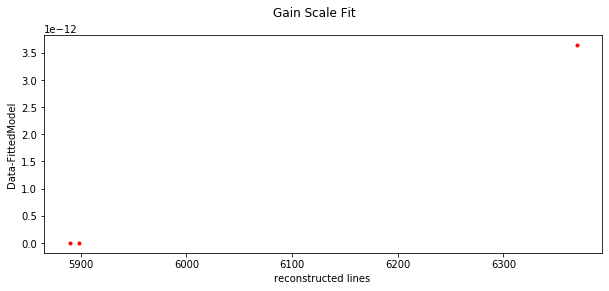

In [45]:
############## SELECT THE LEVEL OF CORRECTION (MAITE'S) ###################################
#dataKas_HR_corrected = np.copy(dataKas_HR_jitter_bsln)  # Kas no drift corrected   
dataKb_HR_corrected = np.copy(dataKb_HR_jitter_bsln)  # Kbeta no drift corrected
dataKas_HR_corrected = np.copy(dataKas_HR_jitter_bsln_drift)  
print(len(dataKas_HR_corrected))
print(dataKas_HR_corrected[0:10])

############## SELECT THE LEVEL OF CORRECTION (NICO'S) ###################################
dataKas_HR_corrected = np.copy(df.SIGNAL_cTIME_cPHI)  
#print(len(dataKas_HR_corrected))
#print(dataKas_HR_corrected[0:10])

corrected ="jitter_bsln_drift"

## 4. Fit gaussians, create Gain scale and calibrate energies

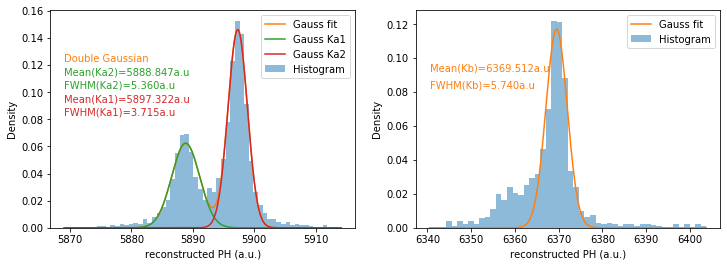

In [46]:
# Pre-calibration histogram
plt.close()
nbinsKas = 60
nbinsKb = 50
if plen == 8000:
    centresA=[5889,5898] # for pL8000
    centresB=6368
elif plen == 4096:
    centresA=[7855,7865] # for pL4096
    centresB=8345
(mean1bsln, mean2bsln, mean3bsln) = fit3gauss2hist(data1=1e3*dataKas_HR_corrected, data2=1e3*dataKb_HR_corrected,
                                        a1=0.06, a2=0.12, a3=0.1, sig1=5, sig2=5, sig3=5, 
                                        mean1=centresA[0], mean2=centresA[1], mean3=centresB,
                                        nbins1=nbinsKas, nbins2=nbinsKb, 
                                        xlab="reconstructed PH (a.u.)", plot=True, xsize=12,ysize=4)

In [47]:
# create gain scale Ka2, Ka1, Kb
#plt.close()
calib_lines = tuple([float(x) for x in (lines)])
recon_lines = (mean1bsln,mean2bsln, mean3bsln)

#calib_lines = tuple([float(x) for x in (lines[0:2])])
#print(calib_lines)
#recon_lines = (mean1bsln,mean2bsln)

coefs = gainScalePolyFit(xData=recon_lines, yData=calib_lines, deg=2, ylab="MnK Lines energies (eV)", xsize=10, ysize=4)
print("gain scale coefs=", coefs)

RMSE: 1.964733109588712e-12
R-squared: 1.0
gain scale coefs= [-1.40728915e+03  1.22312894e+00  2.64831947e-06]


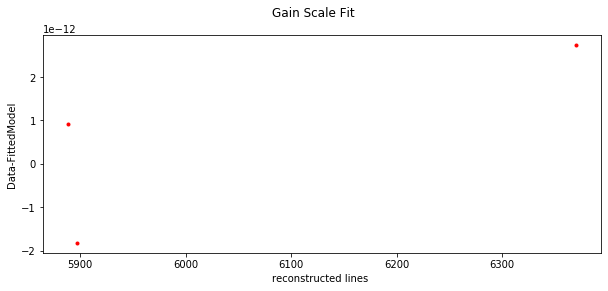

In [48]:
minEeV_Ka=5860
maxEeV_Ka=5920
#minEeV_Ka=5880
#maxEeV_Ka=5905

minEeV_Kb=6450
maxEeV_Kb=6505
# recalibrate energies
enerKas_HR_corrected = np.zeros(len(dataKas_HR_corrected))
enerKb_HR_corrected = np.zeros(len(dataKb_HR_corrected))

for i in range(len(coefs)):
    enerKas_HR_corrected += coefs[i] * (1e3*dataKas_HR_corrected)**(i)
enerKas_HR_corrected = enerKas_HR_corrected[(enerKas_HR_corrected > minEeV_Ka) & (enerKas_HR_corrected < maxEeV_Ka)]

for i in range(len(coefs)):
    enerKb_HR_corrected += coefs[i] * (1e3*dataKb_HR_corrected)**(i)
enerKb_HR_corrected = enerKb_HR_corrected[(enerKb_HR_corrected>minEeV_Kb) & (enerKb_HR_corrected<maxEeV_Kb)]


## 4 Fit histogram of corrected+gainscale_calib0 energies

#### 4.1 Test different number of bins and see how the residuals respond

In [49]:
%%script false --no-raise-error
# Plot residuals curve to select best number of bins for Kas and Kb
plt.clf()
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=np.arange(20,200,20), ax0=ax1)
ax1.set_title("MnKas")

fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=np.arange(40,150,10), ax0=ax2)
ax2.set_title("MnKb")

#### 4.2 Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then take median value

In [50]:
#%%script false --no-raise-error
# Calculate mean 'fit' for range of acceptable number of bins in Kas range
#                                                               ===========
(ibmin, ibmax) = (100, 300)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKas in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)    
    plt.clf()
    if fw < 0 or efw == 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKas)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKas = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKas[median_index]=", nbins[median_index])

print("Using ", len(fwhm_G), "different number of bins")
txt_Kas = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kas)=", txt_Kas)


FWHM_Gs= [2.258 2.266 2.265 2.235 2.215 2.232 2.242 2.247 2.227 2.243 2.230 2.246
 2.240 2.225 2.240 2.236 2.210 2.229 2.222 2.226]
median_index= 3
FWHM_G[median_index]= 2.2351973206677376
ERR_FWHM_G[median_index]= 0.055044582476320734
nbinsKas[median_index]= 130
Using  20 different number of bins
Median FWHM_G(Kas)= 2.24+/-0.06eV


<Figure size 432x288 with 0 Axes>

In [51]:
#%%script false --no-raise-error

# Calculate mean 'fit' for range of acceptable number of bins in Kb range
#                                                               ===========
(ibmin, ibmax) = (50, 100)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKb in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)    
    plt.clf()
    if efw == 0 or fw < 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKb)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKb = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKb[median_index]=", nbins[median_index])

txt_Kb = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kb)=", txt_Kb)

FWHM_Gs= [3.368 3.395 3.351 3.243 3.313]
median_index= 2
FWHM_G[median_index]= 3.3512344901878803
ERR_FWHM_G[median_index]= 0.20293574244245305
nbinsKb[median_index]= 70
Median FWHM_G(Kb)= 3.35+/-0.20eV


<Figure size 432x288 with 0 Axes>

Using nbinsKas= 130 from median estimation
Using nbinsKb= 70 from median estimation
2.2351973206677376 0.055044582476320734
3.3512344901878803 0.20293574244245305


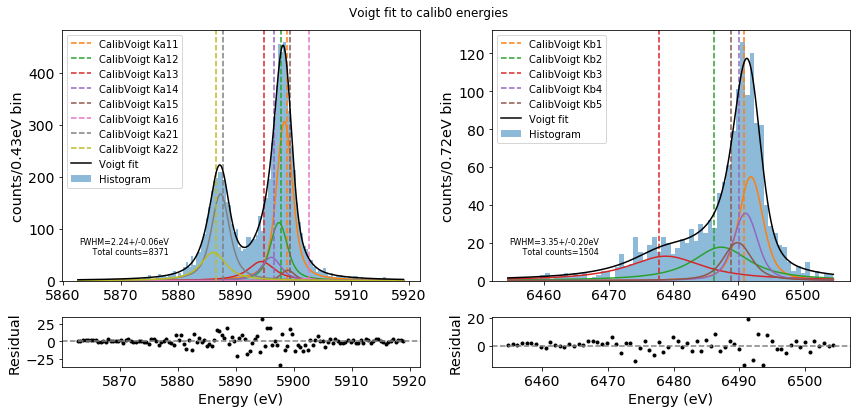

In [52]:
#%%script false --no-raise-error
#plt.close()
# Plot representative (median) fitting 
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Voigt fit to calib0 energies")
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

print("Using nbinsKas=", nbinsKas, "from median estimation")
print("Using nbinsKb=", nbinsKb, "from median estimation")

nlines_Kas = MnKas.getNumber() 
nlines_Kb = MnKb.getNumber()
nlines = nlines_Kas + nlines_Kb 
lines_centres_vv = np.zeros(nlines)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)
print(fwhm_G, err_fwhm_G)
for i in range(nlines_Kas):
     lines_centres_vv[i] = vvmod.param_sets[i*4][0]
info = "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_HR_corrected))
ax1.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes, fontsize=8)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)
print(fwhm_G, err_fwhm_G)
for i in range(nlines_Kb):
    j = i + nlines_Kas
    lines_centres_vv[j] = vvmod.param_sets[i*4][0]
info = "FWHM=" + txt_Kb + "\n Total counts=" + str(len(enerKb_HR_corrected))
ax2.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes, fontsize=8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## 5. Recalibrate energies:
      - get new gain scale with fitted line centres
      - recalibrate energies
      - fit again to get FWHM more precisely

In [53]:
# reverse au to energy transformation of lines centres using gain scale
#lines_centres_Kas 
# Ecal = coefs[0] + coefs[1] * PHau + coefs[2] * PHau^2 + ....
# to get roots:    0 = coefs[0]-Ecal + coefs[1] * PHau + coefs[2] * PHau^2 + ....
PHau = np.zeros(nlines)
newcoefs = np.zeros(len(coefs))
np.copyto(newcoefs, coefs)
#print(coefs)
for i in range(nlines):  
    line = lines_centres_vv[i]
    #print("line=", line)
    coef0 = coefs[0] - line
    newcoefs[0] = coef0
    calpoly = P(newcoefs)
    roots = calpoly.roots()
    #print("Roots=", roots)
    PHau[i] = roots[np.abs(line-roots).argmin()]
    #PHau[i] = max(calpoly.roots())
    #if abs(line - PHau[i]) > 1000:
    #    PHau[i] = min(calpoly.roots())
    #if abs(line - PHau[i]) > 5000:
    #    raise RuntimeError("PH root in a.u. is too different from line Energy (eV)")
    
    #print(calpoly.roots())
    print("PH for ", line, "=", PHau[i])

PH for  5898.440120636033 = 5897.672581110511
PH for  5897.456194346491 = 5896.888179022813
PH for  5894.422421620403 = 5894.469589563551
PH for  5896.124294125282 = 5895.82636230184
PH for  5899.002078537174 = 5898.1205819502065
PH for  5902.2698337345555 = 5900.725666126259
PH for  5887.330952875046 = 5888.816020421226
PH for  5886.087046061845 = 5887.824320098233
PH for  6491.956358711202 = 6370.360891628324
PH for  6487.375606283892 = 6366.71629352895
PH for  6478.794196714827 = 6359.88848965659
PH for  6491.126222354287 = 6369.700411846256
PH for  6489.896020283197 = 6368.721625173964


Creating new gain scale using lines with Fitted Energies:
 [5887.8243201  5888.81602042 5894.46958956 5895.8263623  5896.88817902
 5897.67258111 5898.12058195 5900.72566613 6359.88848966 6366.71629353
 6368.72162517 6369.70041185 6370.36089163]
True energies of lines are:
 [5886.528 5887.772 5894.864 5896.566 5897.898 5898.882 5899.444 5902.712
 6477.73  6486.31  6488.83  6490.06  6490.89 ]
RMSE: 0.00020962389235550704
R-squared: 0.999999999999469
gain scale coefs= [ 7.10165346e+04 -4.71700498e+01  1.21178278e-02 -1.34674440e-06
  5.60848117e-11]


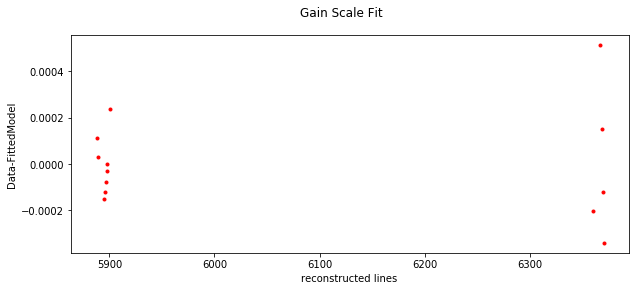

In [54]:
# create NEW gain scale Ka2, Ka1, Kb
#plt.close()
ph_lines = np.sort(PHau)
print("Creating new gain scale using lines with Fitted Energies:\n", ph_lines)
true_lines = np.sort(np.concatenate((MnKas.energies_eV, MnKb.energies_eV)))
print("True energies of lines are:\n",true_lines)
coefs_final = gainScalePolyFit(xData=ph_lines, yData=true_lines, deg=4, ylab="MnK Lines energies (eV)")
print("gain scale coefs=", coefs_final)


In [55]:
# FINAL recalibration of energies
enerKas_final = np.zeros(len(dataKas_HR_jitter_bsln))
enerKb_final = np.zeros(len(dataKb_HR_jitter_bsln))

for i in range(len(coefs_final)):
    enerKas_final += coefs_final[i] * (1e3*dataKas_HR_jitter_bsln)**(i)
    #enerKas_final = inter + slope * 1e3*dataKas_HR_jitter_bsln # eV
enerKas_final = enerKas_final[(enerKas_final > minEeV_Ka) & (enerKas_final < maxEeV_Ka)]

for i in range(len(coefs_final)):
    enerKb_final += coefs_final[i] * (1e3*dataKb_HR_jitter_bsln)**(i)
    #enerKb_final = inter + slope * 1e3*dataKb_HR_jitter_bsln # eV
enerKb_final = enerKb_final[(enerKb_final>minEeV_Kb) & (enerKb_final<maxEeV_Kb)]


In [56]:
#%%script false --no-raise-error

# Calculate median 'fit' for range of acceptable number of bins in Kas range
#                                                               ===========
(ibmin, ibmax) = (100, 250)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKas in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKas_final, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)    
    plt.clf()
    if fw < 0 or efw == 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKas)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKas = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKas[median_index]=", nbins[median_index])

print("Using ", len(fwhm_G), "different number of bins")
txt_Kas = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kas)=", txt_Kas)


FWHM_Gs= [2.910 2.902 2.890 2.901 2.876 2.904 2.888 2.881 2.890 2.886 2.879 2.896
 2.883 2.890]
median_index= 8
FWHM_G[median_index]= 2.8901965650443984
ERR_FWHM_G[median_index]= 0.059186495720483165
nbinsKas[median_index]= 190
Using  14 different number of bins
Median FWHM_G(Kas)= 2.89+/-0.06eV


<Figure size 432x288 with 0 Axes>

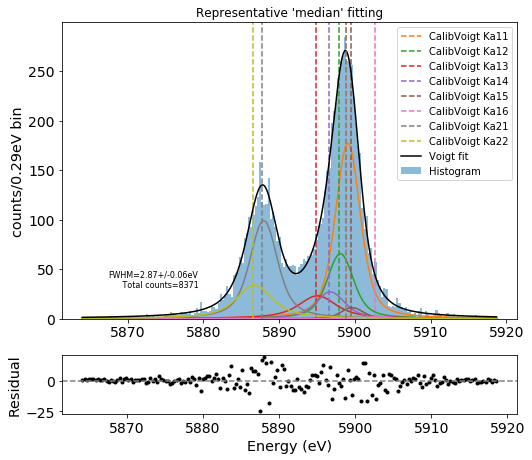

In [41]:
#%%script false --no-raise-error
plt.close()
# Plot representative (median) fitting 
#                    =====================
fig = plt.figure(figsize=(14, 6.5))
ax1 = fig.add_subplot(1,2,1)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_final, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)
#print(fwhm_G, err_fwhm_G)
info = "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_final))
ax1.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes, fontsize=8)
ax1.axvline(MnKas.energies_eV[0], ls="--", color="gray")
ax1.set_title("Representative 'median' fitting")


outfig=resDir + "/fit_" + "pL" + str(plen) + "_" + method + str(oflen) + pBstr + "_final.png"
fig.tight_layout()
fig.savefig(outfig)